In [1]:
%load_ext autoreload
%autoreload 2

from importers import SpikeImporter

data_folder = "../data/"
file_name = "11_10_27U2a_2000s_2300s_20000Hz_Force_AllFibres"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["801 nw-1", "12 nw-1", "14 nw-1"]
force_channel = "3 Force"
# extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)

print("Data loaded.")

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005
force_thresh = 0.5

# retrieve the events from the importer 
el_stimuli = importer.getElectricalStimuli(regular_stimulus_channel = stimulus_channel)
# ex_stimuli = importer.getExtraStimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli)
mech_stimuli = importer.getMechanicalStimuli(force_channel = force_channel, threshold = force_thresh, max_gap_time = 0.005)
actpots = importer.getActionPotentials(max_gap_time = max_gap_time, ap_marker_channels = ap_marker_channels, \
                                       el_stimuli = el_stimuli, mech_stimuli = mech_stimuli)

Data loaded.
List of eletrical stimuli created.
List of mechanical stimuli created.
Finished processing AP channel 1 out of 3
Finished processing AP channel 2 out of 3
Finished processing AP channel 3 out of 3
List of APs created.


In [11]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
from metrics import clustering_metrics

from sklearn.cluster import DBSCAN
import numpy as np

# build feature vectors from the features provided by AP class
features = np.array([[ap.getDistanceToPreviousRegularElectricalStimulus(), ap.getNormalizedEnergy()] for ap in actpots])
labels = DBSCAN(eps = 0.001, min_samples = 10, metric = clustering_metrics.TimeDistAndEnergy, metric_params = {'energy_importance': 1e-5}).fit_predict(features)
print("Clustering done.")

Clustering done.


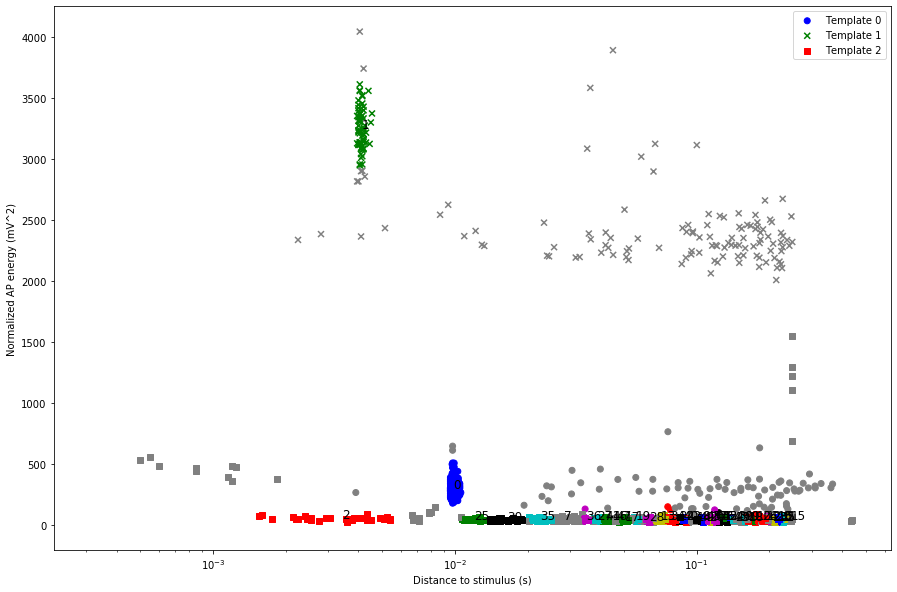

Figure saved.


In [12]:
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from plotting import ClusterPlot2D

# plot and save
cl2dplot = ClusterPlot2D()
cl2dplot.plot(actpots = actpots, feature_vectors = features, cluster_labels = labels, xscale = 'log')
cl2dplot.save_to_file(filename = "../results/dbscan_clustering" + file_name + ".png")

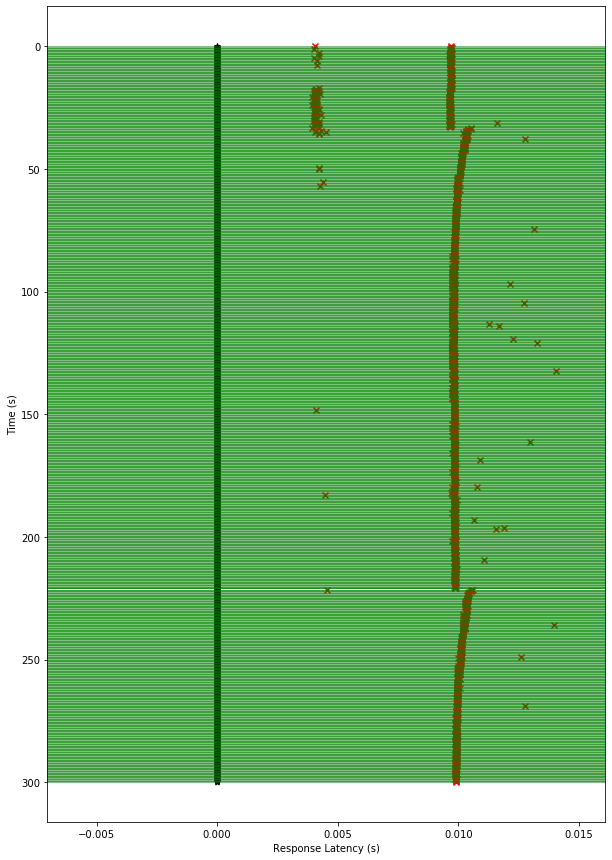

Figure saved.


In [5]:
%autoreload 2

from plotting import FallingLeafPlot
import itertools

clusters_to_plot = [0, 21]
indices = [(True if lbl in clusters_to_plot else False) for lbl in labels]
track_aps = list(itertools.compress(actpots, indices))

flplot = FallingLeafPlot()
flplot.plot(regular_stimuli = el_stimuli, action_potentials = track_aps, plot_hlines = True)
flplot.save_to_file(filename = "../results/falling_leaf_" + file_name + ".png")